In [1]:
import warnings
warnings.filterwarnings('ignore', category=Warning)

In [2]:
import csv
import time
import numpy as np
import torch
import more_itertools
from Bio import SeqIO
from scipy.stats import spearmanr
from utils.bert import BertModel, get_config

import process
import mymodel

In [3]:
class AccDataset(torch.utils.data.Dataset):
    def __init__(self, low_seq, accessibility):
        self.data_num = len(low_seq)
        self.low_seq = low_seq
        self.accessibility = accessibility

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_low_seq = self.low_seq[idx]
        out_accessibility = self.accessibility[idx]

        return out_low_seq, out_accessibility


def make_dl(seq_data_path, acc_data_path, batch_size):
    flag = False
    division = 1
    max_length = 440

    seq_data_path
    seqs = []
    for record in SeqIO.parse(seq_data_path, "fasta"):
        record = record[::-1]  # reverse
        seq = str(record.seq).upper()
        seqs.append(seq)
    seqs_len = np.tile(np.array([len(i) for i in seqs]), 1)

    if max(seqs_len) > max_length:
        flag = True
        division += (max(seqs_len) - 110) // 330
        max_length += division * 330

    # Convert array string to index list with zero padding
    bases_list = []
    for seq in seqs:
        bases = list(seq)
        bases_list.append(bases)
    idx_dict = {"MASK": 1, "A": 2, "U": 3, "T": 3, "G": 4, "C": 5}
    low_seq = torch.tensor(np.array(process.convert(bases_list, idx_dict, max_length)))

    if flag:  # windowing
        splited_seq = []
        for i in low_seq:
            splited_seq.append(list(more_itertools.windowed(i, 440, step=330)))
        low_seq = torch.tensor(splited_seq)
        num_seq, division, length = low_seq.shape
        low_seq = low_seq.view(-1, length)

    accessibility = []
    with open(acc_data_path) as f:
        reader = csv.reader(f)
        for l in reader:
            pad_acc = l + ["-1"] * (max_length - len(l))
            accessibility.append(pad_acc)
    accessibility = torch.tensor(np.array(accessibility, dtype=np.float32))

    if flag:
        splited_acc = []
        for i in accessibility:
            splited_acc.append(list(more_itertools.windowed(i, 440, step=330)))
        accessibility = torch.tensor(splited_acc)
        accessibility = accessibility.view(-1, length)

    ds_ACC = AccDataset(low_seq, accessibility)
    dl_ACC = torch.utils.data.DataLoader(
        ds_ACC, batch_size, num_workers=2, shuffle=False
    )

    return dl_ACC, flag, division


def windowed(target, output, flag, division):
    # Restore a long array
    if flag:
        for i in range(division):
            if i == 0:
                low_tar = target[i::division, :-55]
                low_out = output[i::division, :-55]
            elif i == division - 1:
                target = np.concatenate([low_tar, target[i::division, 55:]], axis=1)
                output = np.concatenate([low_out, output[i::division, 55:]], axis=1)
            else:
                low_tar = np.concatenate([low_tar, target[i::division, 55:-55]], axis=1)
                low_out = np.concatenate([low_out, output[i::division, 55:-55]], axis=1)
        return target, output

    else:
        return target, output


def test(device, model, dataloader, criterion):
    model.to(device)

    data_all = []
    target_all = []
    output_all = []
    loss_all = []
    test_loss = 0
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            low_seq, accessibility = batch
            data = low_seq.to(device, non_blocking=False)
            target = accessibility.to(device, non_blocking=False)
            output = model(data)

            data_all.append(data.cpu().detach().numpy())
            target_all.append(target.cpu().detach().numpy())
            output_all.append(output.cpu().detach().numpy())

            loss = criterion(output, target)
            loss_all.append(loss.item())
            test_loss += loss.item() * data.size(0)
    avg_loss = test_loss / len(dataloader.dataset)

    print(f"normMSELoss:{avg_loss:.4f}")

    data_all = np.concatenate(data_all)
    target_all = np.concatenate(target_all)
    output_all = np.concatenate(output_all)

    return data_all, target_all, output_all, loss_all

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_path = "sample_data/sequence/RF01000.fa"
acc_path = "sample_data/accessibility/RF01000.csv"

model_type = "FCN"
batch_size = 256
criterion = mymodel.normMSE().to(device)

In [5]:
model = getattr(mymodel, model_type)()
model = process.model_device(model, device)
model.load_state_dict(
    torch.load("path/FCN_structured.pth", map_location=device)["model_state_dict"]
)
model = model.module.to(device)

dl, flag, division = make_dl(seq_path, acc_path, batch_size)
data, target, output, loss = test(device, model, dl, criterion)
target, output = windowed(target, output, flag, division)

target_rem, output_rem = process.remove_padding(
    torch.tensor(target), torch.tensor(output)
)

device:  cpu


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


normMSELoss:0.2369


In [6]:
print(target_rem[:5])
print(output_rem[:5])

tensor([22.5623, 22.5902, 22.6216, 22.6420, 22.6525])
tensor([22.0823, 22.1020, 22.2422, 22.3530, 22.4678])


In [7]:
correlation, pvalue = spearmanr(
    np.array(target_rem).flatten(), np.array(output_rem).flatten()
)
print(f"correlation:{correlation:.4f}, pvalue:{pvalue:.4f}")

correlation:0.9411, pvalue:0.0000


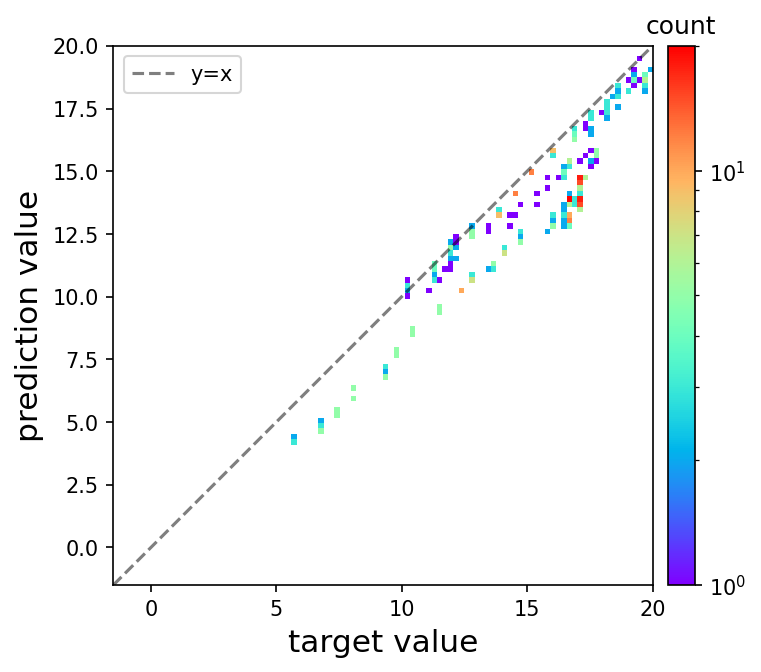

In [8]:
process.plot_result(
    np.array(target_rem), np.array(output_rem), mode="show"
)